<a href="https://colab.research.google.com/github/devil-of-silicon-valley/cmpe255-project/blob/main/Baseline/Program_Baseline_Shabab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Group 5:  Reuter_50_50 Data Set (https://archive.ics.uci.edu/ml/datasets/Reuter_50_50Links to an external site.)

Identify the author of an article based on attributes describing their writing style

**GOAL: Identify the author of an article based on attributes describing their writing style**

In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import libaries
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import f1_score
from glob import glob
import json

In [3]:
# setup debug for prints troubleshooting
debug = True

In [4]:
def load_json(json_file):
  with open(json_file) as f:
    data = json.load(f)
  return data

def write_json(json_file, data):
  with open(json_file, "w") as outfile:
    json.dump(data, outfile)

## Initial Dataset Construction

The following code was used to parse the raw dataset to create training and testing JSONs that will be used for classification models.

These resulting JSONs will also make it faster to load the dataset.

In [ ]:
# get the train and set directories
train_dir = '/content/drive/MyDrive/Assignments/03: FA24: CMPE-255 Sec 33 - Data Mining/Project/C50train'
test_dir = '/content/drive/MyDrive/Assignments/03: FA24: CMPE-255 Sec 33 - Data Mining/Project/C50test'

In [ ]:
# create a function to load the data from the directories
def parse_raw_data(dir, json_save_dir, debug=False):

  print(f"Creating JSON from data in {dir}")

  # initialize empty dictionary to fill with author information
  data_dict = {}

  # get the list of author directories
  author_dirs = sorted(glob(f"{dir}/*"))
  print(f"Found {len(author_dirs)} authors...")

  # now parse the directories for the author names and their associated texts
  for author_dir in author_dirs:

    # get the author name from the directory
    author_name = author_dir.split('/')[-1]

    if debug: print(f"Loading files for {author_name}")

    total_files = len(glob(f"{author_dir}/*.txt"))
    if debug: print(f"Found {total_files} files for {author_name}")

    author_file_entry = {}
    for file_entry in sorted(glob(f"{author_dir}/*.txt")):
      # get te filename (ex: 2537newsML.txt)
      author_filename = file_entry.split('/')[-1]
      # Read the file and remove any new lines or raw strings
      author_file = open(file_entry, "r").read().replace('\n', '').replace('\r', '')
      # create the dictionary accordingly
      author_file_entry[author_filename] = author_file
      # example of an entry "Author1" : {"1234text.txt" : "Text for this entry"}

    if debug: print(f"Adding {author_name} to data dictionary")

    # add the dictionary entry for the current author and their files
    data_dict[author_name] = author_file_entry

  write_json(json_save_dir, data_dict)

  return data_dict

In [ ]:
train_json_save_dir = '/content/drive/MyDrive/Assignments/03: FA24: CMPE-255 Sec 33 - Data Mining/Project/C50train.json'
test_json_save_dir = '/content/drive/MyDrive/Assignments/03: FA24: CMPE-255 Sec 33 - Data Mining/Project/C50test.json'
train_json = parse_raw_data(dir=train_dir, json_save_dir=train_json_save_dir)
test_json = parse_raw_data(dir=test_dir, json_save_dir=test_json_save_dir)

Creating JSON from data in /content/drive/MyDrive/Assignments/03: FA24: CMPE-255 Sec 33 - Data Mining/Project/C50train
Found 50 authors...
Creating JSON from data in /content/drive/MyDrive/Assignments/03: FA24: CMPE-255 Sec 33 - Data Mining/Project/C50test
Found 50 authors...


## Loading the JSON to make a Dataframe

In [ ]:
# read the jsons
train_json_save_dir = '/content/drive/MyDrive/Assignments/03: FA24: CMPE-255 Sec 33 - Data Mining/Project/C50train.json'
test_json_save_dir = '/content/drive/MyDrive/Assignments/03: FA24: CMPE-255 Sec 33 - Data Mining/Project/C50test.json'
train_json = load_json(train_json_save_dir)
test_json = load_json(test_json_save_dir)

Let's try making a dataframe from the JSON we just loaded

In [ ]:
train_data_df = pd.DataFrame(train_json, index=None).T
test_data_df = pd.DataFrame(test_json, index=None).T

In [ ]:
train_data_df.head()

,106247newsML.txt,120600newsML.txt,120683newsML.txt,136958newsML.txt,137498newsML.txt,14014newsML.txt,156814newsML.txt,182596newsML.txt,186392newsML.txt,193495newsML.txt,...,258689newsML.txt,264132newsML.txt,268647newsML.txt,278687newsML.txt,281216newsML.txt,28223newsML.txt,282935newsML.txt,287736newsML.txt,289747newsML.txt,304402newsML.txt
AaronPressman,The Internet may be overflowing with new techn...,The U.S. Postal Service announced Wednesday a ...,Elementary school students with access to the ...,An influential Internet organisation has backe...,An influential Internet organisation has backe...,A group of leading trademark specialists plans...,When a company in California sells a book to a...,U.S. laws governing the trillion dollar future...,Supreme Court justices Wednesday sharply quest...,The Internet continued to grow in leaps and bo...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AlanCrosby,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AlexanderSmith,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BenjaminKangLim,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BernardHickey,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


This isnt't very useful because of the NaNs.

Refactor the JSON so it's a cleaner more usable format

In [ ]:
# this function will refactor the data dictionary to a format
# that is more friendly for dataframes
def refactor_data(data_dict):

  # create the dictionary that will be converted to a dataframe
  refactored_data_dict = {}

  # init list of unique authors
  authors = []

  # init raw labels (authors) and data (text)
  # that will be used for actual training
  labels = []
  data = []

  # parse the dictionary to get the files for each author
  for author_entry, file_entry in data_dict.items():

    # init the text list for each author
    text_list = []

    # add the current author to the list of total authors
    authors.append(author_entry)

    # parse the text list to add to the relevant lists
    for file_name, file_text in file_entry.items():
      labels.append(author_entry)
      data.append(file_text)

    refactored_data_dict[author_entry] = data

  data_df = pd.DataFrame(refactored_data_dict, index=None).T

  return data_df, authors, labels, data

In [ ]:
train_data_df, train_authors, train_labels, train_data = refactor_data(train_json)
test_data_df, test_authors, test_labels, test_data = refactor_data(test_json)

In [ ]:
train_data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
AaronPressman,The Internet may be overflowing with new techn...,The U.S. Postal Service announced Wednesday a ...,Elementary school students with access to the ...,An influential Internet organisation has backe...,An influential Internet organisation has backe...,A group of leading trademark specialists plans...,When a company in California sells a book to a...,U.S. laws governing the trillion dollar future...,Supreme Court justices Wednesday sharply quest...,The Internet continued to grow in leaps and bo...,...,China has taken its cue from U.S. Federal Rese...,"The Stone Group, a Chinese high technology com...",China said on Thursday it strongly opposed a v...,A top Chinese defence official has stepped dow...,China warned on Monday against reinforcing mil...,China's central bank chief has said that infla...,"China ushered in 1997, a year it has hailed as...",China issued tough new rules on the handling o...,China will avoid bold moves in tackling its ai...,Communist Party chief Jiang Zemin has put his ...
AlanCrosby,The Internet may be overflowing with new techn...,The U.S. Postal Service announced Wednesday a ...,Elementary school students with access to the ...,An influential Internet organisation has backe...,An influential Internet organisation has backe...,A group of leading trademark specialists plans...,When a company in California sells a book to a...,U.S. laws governing the trillion dollar future...,Supreme Court justices Wednesday sharply quest...,The Internet continued to grow in leaps and bo...,...,China has taken its cue from U.S. Federal Rese...,"The Stone Group, a Chinese high technology com...",China said on Thursday it strongly opposed a v...,A top Chinese defence official has stepped dow...,China warned on Monday against reinforcing mil...,China's central bank chief has said that infla...,"China ushered in 1997, a year it has hailed as...",China issued tough new rules on the handling o...,China will avoid bold moves in tackling its ai...,Communist Party chief Jiang Zemin has put his ...
AlexanderSmith,The Internet may be overflowing with new techn...,The U.S. Postal Service announced Wednesday a ...,Elementary school students with access to the ...,An influential Internet organisation has backe...,An influential Internet organisation has backe...,A group of leading trademark specialists plans...,When a company in California sells a book to a...,U.S. laws governing the trillion dollar future...,Supreme Court justices Wednesday sharply quest...,The Internet continued to grow in leaps and bo...,...,China has taken its cue from U.S. Federal Rese...,"The Stone Group, a Chinese high technology com...",China said on Thursday it strongly opposed a v...,A top Chinese defence official has stepped dow...,China warned on Monday against reinforcing mil...,China's central bank chief has said that infla...,"China ushered in 1997, a year it has hailed as...",China issued tough new rules on the handling o...,China will avoid bold moves in tackling its ai...,Communist Party chief Jiang Zemin has put his ...
BenjaminKangLim,The Internet may be overflowing with new techn...,The U.S. Postal Service announced Wednesday a ...,Elementary school students with access to the ...,An influential Internet organisation has backe...,An influential Internet organisation has backe...,A group of leading trademark specialists plans...,When a company in California sells a book to a...,U.S. laws governing the trillion dollar future...,Supreme Court justices Wednesday sharply quest...,The Internet continued to grow in leaps and bo...,...,China has taken its cue from U.S. Federal Rese...,"The Stone Group, a Chinese high technology com...",China said on Thursday it strongly opposed a v...,A top Chinese defence official has stepped dow...,China warned on Monday against reinforcing mil...,China's central bank chief has said that infla...,"China ushered in 1997, a year it has h

This looks a lot better. Maybe this can be used to create a classification model.

## Experimenting with Classification Models

In [5]:
# read the jsons
train_json_save_dir = '/content/drive/MyDrive/Assignments/03: FA24: CMPE-255 Sec 33 - Data Mining/Project/C50train.json'
test_json_save_dir = '/content/drive/MyDrive/Assignments/03: FA24: CMPE-255 Sec 33 - Data Mining/Project/C50test.json'

train_json = load_json(train_json_save_dir)
test_json = load_json(test_json_save_dir)

# this function will refactor the data dictionary to a format
# that is more friendly for dataframes
def refactor_data(data_dict):
  # create the dictionary that will be converted to a dataframe
  refactored_data_dict = {}
  # init list of unique authors
  authors = []
  # init raw labels (authors) and data (text)
  # that will be used for actual training
  labels = []
  data = []
  # parse the dictionary to get the files for each author
  for author_entry, file_entry in data_dict.items():
    # init the text list for each author
    text_list = []
    # add the current author to the list of total authors
    authors.append(author_entry)
    # parse the text list to add to the relevant lists
    for file_name, file_text in file_entry.items():
      labels.append(author_entry)
      data.append(file_text)
    refactored_data_dict[author_entry] = data
  data_df = pd.DataFrame(refactored_data_dict, index=None).T
  return data_df, authors, labels, data

train_data_df, train_authors, train_labels, train_data = refactor_data(train_json)
test_data_df, test_authors, test_labels, test_data = refactor_data(test_json)

In [8]:
train_labels_np = np.array(train_labels)
train_data_np = np.array(train_data)
test_labels_np = np.array(test_labels)
test_data_np = np.array(test_data)

In [9]:
# split the test data
X_train, X_test, y_train, y_test = train_test_split(train_data_np, train_labels_np, test_size=0.2, random_state=1)

In [10]:
# vectorize x_train and x_test from text to matrix
vect = TfidfVectorizer(stop_words='english')

# vectorize the training data
x_train_vec = vect.fit_transform(X_train)
x_test_vec = vect.transform(X_test)

# vectorize the actual test set
test_data_vec = vect.transform(test_data)

In [ ]:
model = LogisticRegression()
model.fit(x_train_vec,y_train)

LogisticRegression()

In [ ]:
predictions = model.predict(x_test_vec)
f1 = f1_score(y_test, predictions, average='weighted')
print(f1)

0.7566549076310686


In [ ]:
predictions = model.predict(test_data_vec)
f1 = f1_score(test_labels_np, predictions, average='weighted')
print(f1)

0.629295408142437


In [ ]:
rep = classification_report(test_labels_np, predictions)
print(rep)

                   precision    recall  f1-score   support

    AaronPressman       0.85      0.92      0.88        50
       AlanCrosby       0.82      0.46      0.59        50
   AlexanderSmith       0.71      0.24      0.36        50
  BenjaminKangLim       0.34      0.20      0.25        50
    BernardHickey       0.65      0.44      0.52        50
      BradDorfman       0.63      0.82      0.71        50
 DarrenSchuettler       0.33      0.28      0.30        50
      DavidLawder       0.58      0.28      0.38        50
    EdnaFernandes       0.80      0.48      0.60        50
      EricAuchard       0.39      0.44      0.41        50
   FumikoFujisaki       0.93      1.00      0.96        50
   GrahamEarnshaw       0.75      0.90      0.82        50
 HeatherScoffield       0.33      0.38      0.35        50
       JanLopatka       0.57      0.34      0.42        50
    JaneMacartney       0.17      0.14      0.15        50
     JimGilchrist       0.89      1.00      0.94       

In [11]:
model = RandomForestClassifier()
model.fit(x_train_vec,y_train)

RandomForestClassifier()

In [12]:
predictions = model.predict(x_test_vec)
f1 = f1_score(y_test, predictions, average='weighted')
print(f1)

0.7459424534215513


In [13]:
predictions = model.predict(test_data_vec)
f1 = f1_score(test_labels_np, predictions, average='weighted')
print(f1)

0.6088070149130282


In [14]:
rep = classification_report(test_labels_np, predictions)
print(rep)

                   precision    recall  f1-score   support

    AaronPressman       0.69      0.94      0.80        50
       AlanCrosby       0.91      0.58      0.71        50
   AlexanderSmith       0.56      0.46      0.51        50
  BenjaminKangLim       0.22      0.40      0.28        50
    BernardHickey       0.63      0.24      0.35        50
      BradDorfman       0.58      0.56      0.57        50
 DarrenSchuettler       0.25      0.28      0.26        50
      DavidLawder       0.36      0.20      0.26        50
    EdnaFernandes       0.50      0.30      0.38        50
      EricAuchard       0.71      0.30      0.42        50
   FumikoFujisaki       0.86      1.00      0.93        50
   GrahamEarnshaw       0.65      0.98      0.78        50
 HeatherScoffield       0.34      0.42      0.38        50
       JanLopatka       0.52      0.46      0.49        50
    JaneMacartney       0.15      0.04      0.06        50
     JimGilchrist       0.89      1.00      0.94       

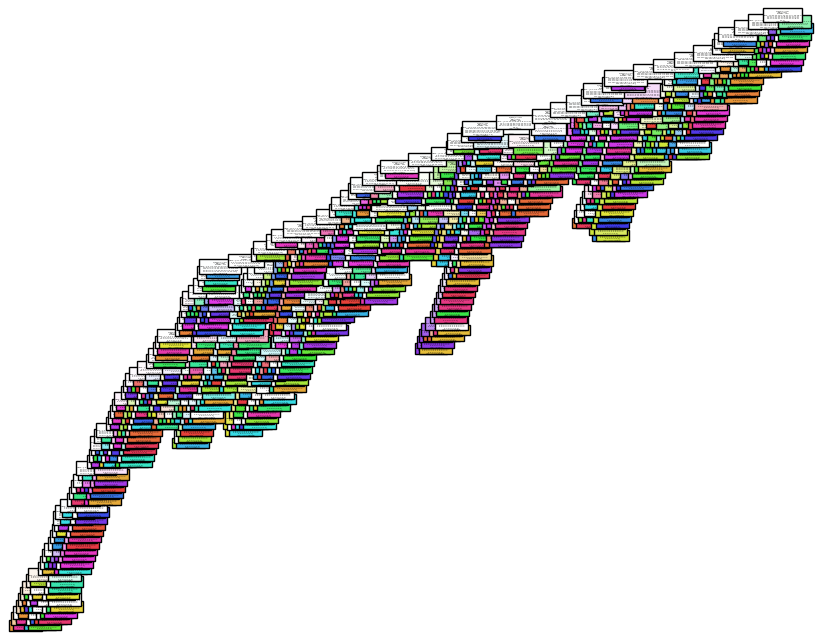

In [15]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
# Plot the first tree in the forest
plt.figure(figsize=(10, 8))
plot_tree(model.estimators_[0],
          class_names=train_authors,
          filled=True)
plt.show()

In [16]:
model = DecisionTreeClassifier()
model.fit(x_train_vec,y_train)

DecisionTreeClassifier()

In [17]:
predictions = model.predict(x_test_vec)
f1 = f1_score(y_test, predictions, average='weighted')
print(f1)

0.5822670949829668


In [18]:
predictions = model.predict(test_data_vec)
f1 = f1_score(test_labels_np, predictions, average='weighted')
print(f1)

0.43339843829630137


In [19]:
rep = classification_report(test_labels_np, predictions)
print(rep)

                   precision    recall  f1-score   support

    AaronPressman       0.52      0.62      0.56        50
       AlanCrosby       0.56      0.36      0.44        50
   AlexanderSmith       0.23      0.18      0.20        50
  BenjaminKangLim       0.27      0.26      0.26        50
    BernardHickey       0.46      0.24      0.32        50
      BradDorfman       0.35      0.46      0.40        50
 DarrenSchuettler       0.26      0.24      0.25        50
      DavidLawder       0.60      0.42      0.49        50
    EdnaFernandes       0.19      0.20      0.19        50
      EricAuchard       0.44      0.36      0.40        50
   FumikoFujisaki       0.87      0.90      0.88        50
   GrahamEarnshaw       0.41      0.62      0.49        50
 HeatherScoffield       0.26      0.28      0.27        50
       JanLopatka       0.38      0.42      0.40        50
    JaneMacartney       0.13      0.08      0.10        50
     JimGilchrist       1.00      1.00      1.00       

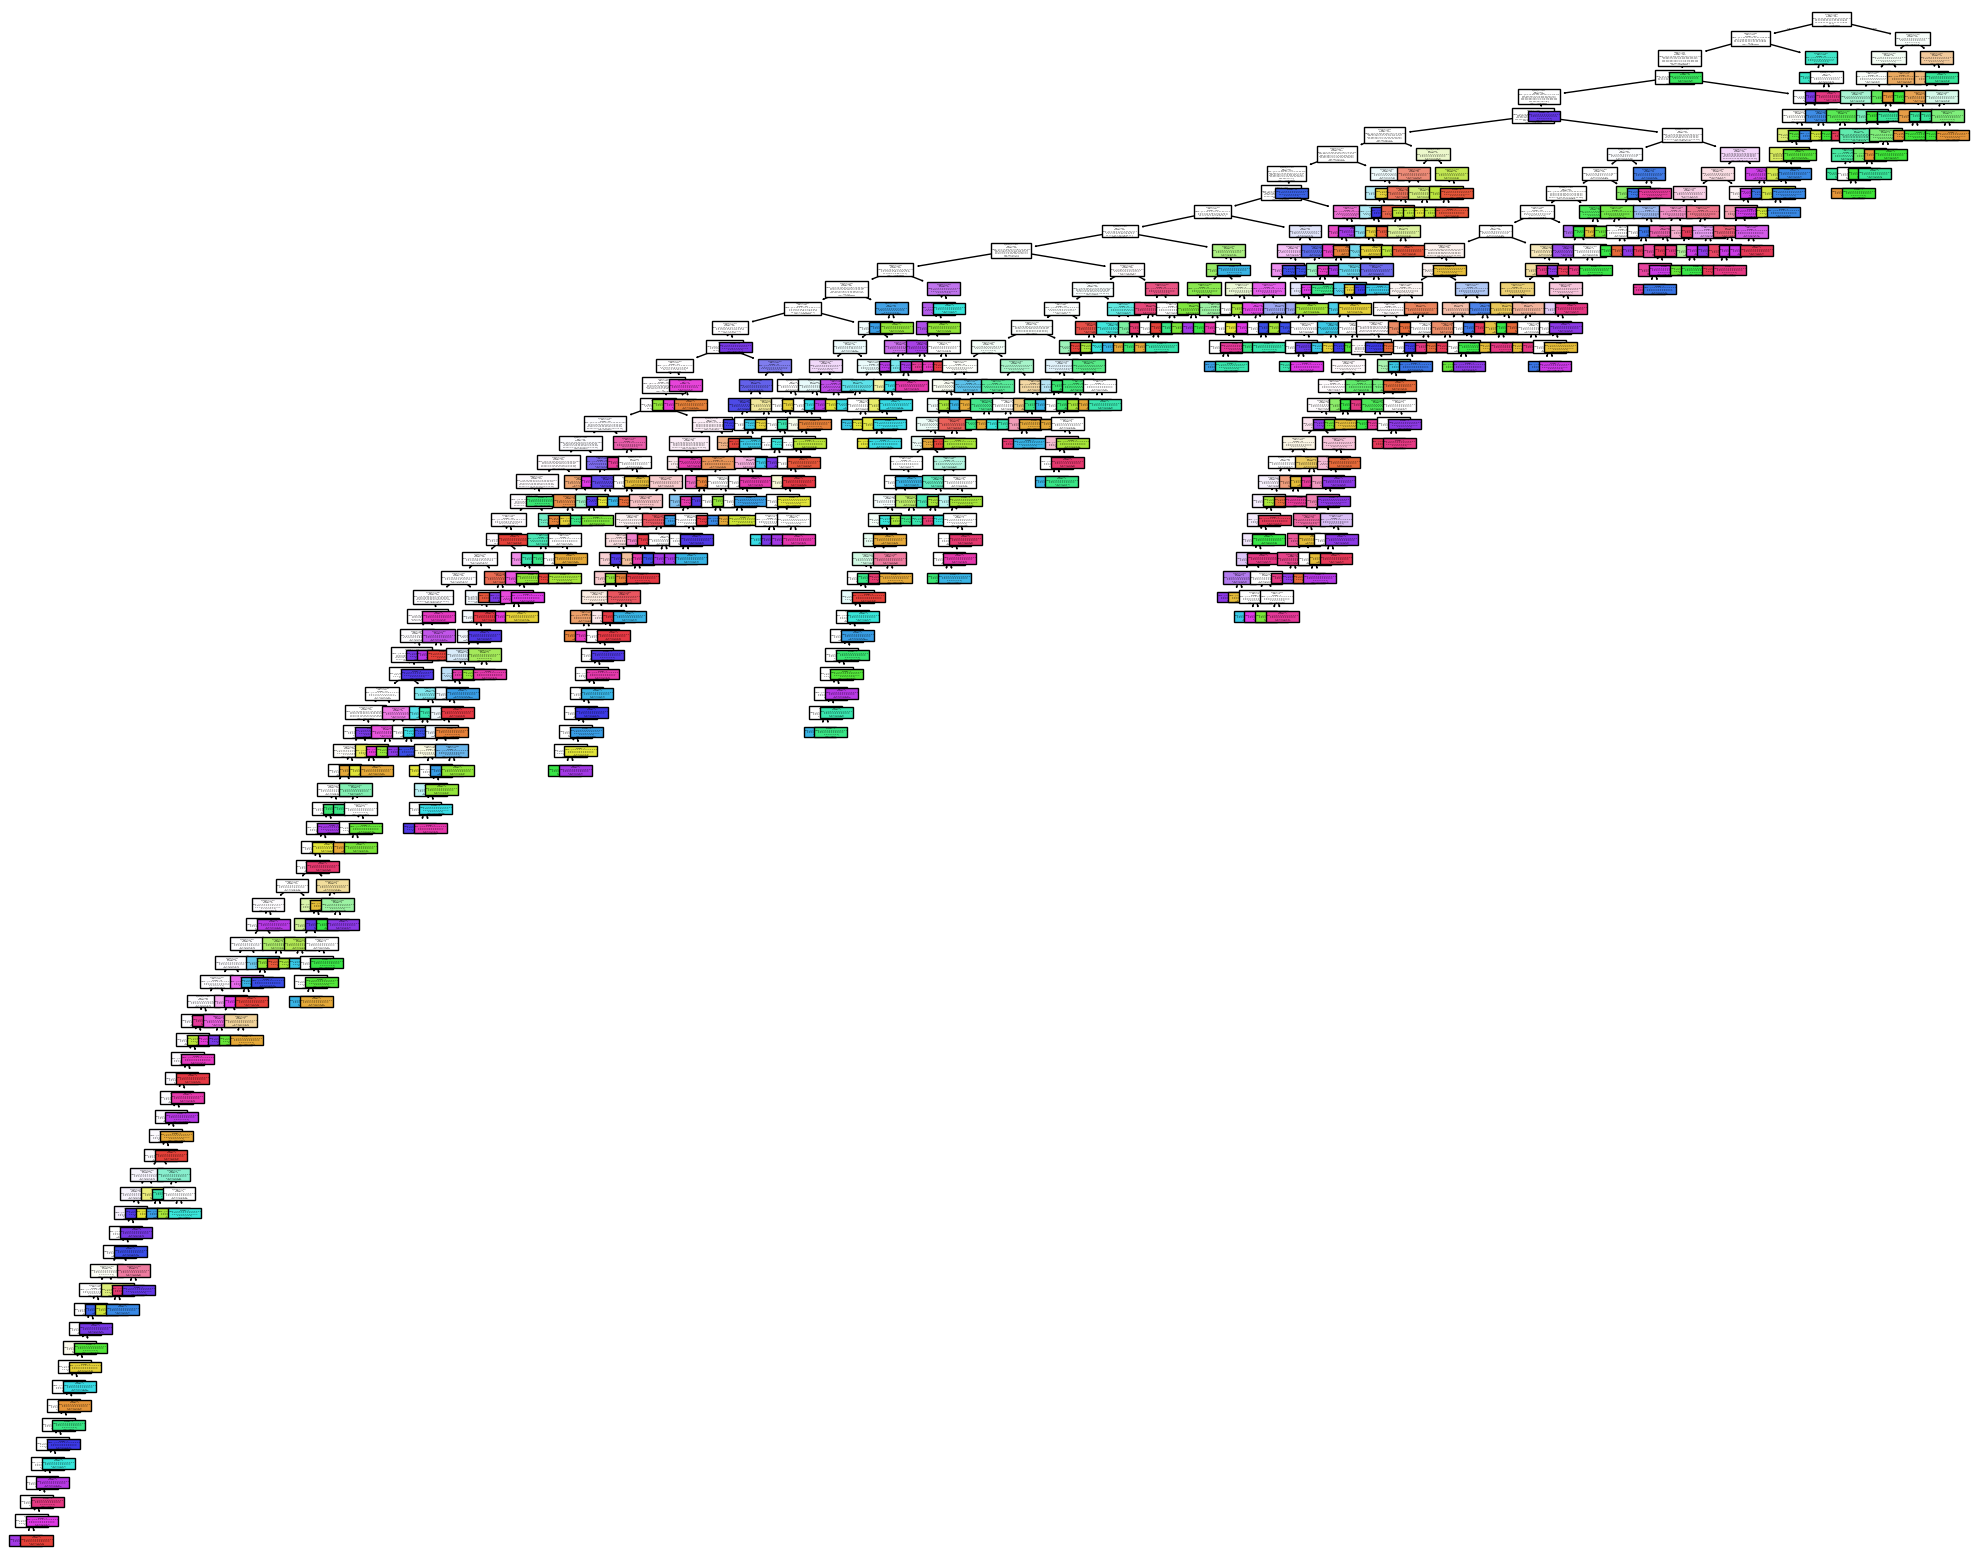

In [20]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model,
                   class_names=train_authors,
                   filled=True)